In [1]:
# ## install finrl library
# !pip install wrds
# !pip install quantstats
# !pip install torch_geometric
# !pip install swig
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# !pip install git+https://github.com/flpymonkey/FinRL-Fork.git

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER

# from finrl.agents.portfolio_optimization.architectures import EIIE

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

# import sys
# sys.path.append("../FinRL-Library")

import itertools

In [4]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [5]:
# TODO, remove DOW from training as it is missing some values in 2019
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [6]:
TRAIN_START_DATE = '2009-04-01'
TRAIN_END_DATE = '2020-12-31'
TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2024-01-01'

# TRAIN_START_DATE = '2010-01-01'
# TRAIN_END_DATE = '2021-10-01'
# TEST_START_DATE = '2021-10-01'
# TEST_END_DATE = '2023-03-01'
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.config_tickers import DOW_30_TICKER


# TODO Drop the DOW stock
value_to_remove = "DOW"
# Create a new list without the specified string
DOW_30_TICKER = [x for x in DOW_30_TICKER if x != value_to_remove]
print(DOW_30_TICKER)

# No time window needed for A2C
# TIME_WINDOW = 25
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000

# TODO try different date ranges
# TRAIN_START_DATE = '2009-01-01'
# TRAIN_END_DATE = '2018-10-01'
# TEST_START_DATE = '2018-10-01'
# TEST_END_DATE = '2021-03-01'

raw_df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (107677, 8)


In [7]:
print(raw_df)

              date        open        high         low       close     volume  \
0       2009-04-01    3.717500    3.892857    3.710357    3.278073  589372000   
1       2009-04-01   48.779999   48.930000   47.099998   34.259617   10850100   
2       2009-04-01   13.340000   14.640000   13.080000   11.463929   27701800   
3       2009-04-01   34.520000   35.599998   34.209999   26.850754    9288800   
4       2009-04-01   27.500000   29.520000   27.440001   19.116177   15308300   
...            ...         ...         ...         ...         ...        ...   
107672  2023-12-29  525.979980  528.239990  523.919983  520.342346    2080100   
107673  2023-12-29  260.570007  261.459991  259.670013  258.866302    4074600   
107674  2023-12-29   37.380001   37.759998   37.320000   35.344772   16205200   
107675  2023-12-29   26.440001   26.629999   25.750000   24.868887   10853300   
107676  2023-12-29   52.509998   52.693333   52.386665   52.042637   21948300   

         tic  day  
0      

In [8]:
# INDICATORS = ['macd',
#             'rsi_30',
#             'cci_30',
#             'dx_30']

In [9]:
# from finrl.meta.preprocessor.preprocessors import FeatureEngineer
# fe = FeatureEngineer(use_technical_indicator=True,
#                      tech_indicator_list = INDICATORS,
#                      use_turbulence=True,
#                      user_defined_feature = False)

# processed = fe.preprocess_data(df)
# processed = processed.copy()
# processed = processed.fillna(0)
# processed = processed.replace(np.inf,0)

# # here you can see the engineered features are added to each stock day
# print(processed)


In [10]:
from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(raw_df)
portfolio_norm_df

,date,open,high,low,close,volume,tic,day
0,2009-04-01,0.018773,0.019501,0.018834,0.016610,0.313329,AAPL,0.5
1,2009-04-01,0.165873,0.164931,0.162829,0.121385,0.216841,AMGN,0.5
2,2009-04-01,0.067544,0.073365,0.066315,0.059964,0.306650,AXP,0.5
3,2009-04-01,0.077397,0.079819,0.077716,0.062400,0.089997,BA,0.5
4,2009-04-01,0.092561,0.098663,0.092690,0.065151,0.243804,CAT,0.5
...,...,...,...,...,...,...,...,...
107672,2023-12-29,0.947712,0.946497,0.952357,0.955325,0.059607,UNH,1.0
107673,2023-12-29,0.990045,0.993200,1.000000,0.992263,0.012072,V,1.0
107674,2023-12-29,0.602806,0.606879,0.608313,0.722691,0.026281,VZ,1.0
107675,2023-12-29,0.272493,0.273690,0.267421,0.363286,0.129006,WBA,1.0


In [11]:
portfolio_norm_df.groupby("tic").count()

,date,open,high,low,close,volume,day
tic,,,,,,,
AAPL,3713,3713,3713,3713,3713,3713,3713
AMGN,3713,3713,3713,3713,3713,3713,3713
AXP,3713,3713,3713,3713,3713,3713,3713
BA,3713,3713,3713,3713,3713,3713,3713
CAT,3713,3713,3713,3713,3713,3713,3713
CRM,3713,3713,3713,3713,3713,3713,3713
CSCO,3713,3713,3713,3713,3713,3713,3713
CVX,3713,3713,3713,3713,3713,3713,3713
DIS,3713,3713,3713,3713,3713,3713,3713


In [12]:
stock_dimension = len(portfolio_norm_df.tic.unique())
print(f"Stock Dimension: {stock_dimension}")

Stock Dimension: 29


In [13]:
df_train = portfolio_norm_df[(portfolio_norm_df["date"] >= TRAIN_START_DATE) & (portfolio_norm_df["date"] <= TRAIN_END_DATE)]
df_2021 = portfolio_norm_df[(portfolio_norm_df["date"] >= TEST_START_DATE) & (portfolio_norm_df["date"] <= "2021-12-31")]
df_2022 = portfolio_norm_df[(portfolio_norm_df["date"] >= "2022-01-01") & (portfolio_norm_df["date"] <= "2022-12-31")]
df_2023 = portfolio_norm_df[(portfolio_norm_df["date"] >= "2023-01-01") & (portfolio_norm_df["date"] < TEST_END_DATE)]

# TODO use the start and end date here

df_train.groupby("tic").count()

,date,open,high,low,close,volume,day
tic,,,,,,,
AAPL,2960,2960,2960,2960,2960,2960,2960
AMGN,2960,2960,2960,2960,2960,2960,2960
AXP,2960,2960,2960,2960,2960,2960,2960
BA,2960,2960,2960,2960,2960,2960,2960
CAT,2960,2960,2960,2960,2960,2960,2960
CRM,2960,2960,2960,2960,2960,2960,2960
CSCO,2960,2960,2960,2960,2960,2960,2960
CVX,2960,2960,2960,2960,2960,2960,2960
DIS,2960,2960,2960,2960,2960,2960,2960


In [14]:
import torch
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
from finrl.meta.env_portfolio_optimization.env_portfolio_opt_stable import PortfolioOptStableEnv

from finrl.agents.portfolio_optimization.models_stable import DRLStableAgent



from stable_baselines3.common.logger import configure


environment = PortfolioOptStableEnv(
        df_train,
        initial_amount=INITIAL_CASH,
        comission_fee_pct=COMMISSION_FEE_PERCENT,
        # time_window=TIME_WINDOW,
        features=["close", "high", "low"],
        normalize_df=None
    )


# TODO figuring out issues with timesteps: https://stackoverflow.com/questions/56700948/understanding-the-total-timesteps-parameter-in-stable-baselines-models

agent_a2c = DRLStableAgent(env = environment)

A2C_model_kwargs = {
                    'n_steps': 50,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

# Lower clip_range makes the stocks flatter, very conservative policy

# TODO try playing around with the number of epochs? n_epochs
# TODO try playing around more with the entropy term, make sure agent does enough exploration during training
# TODO try playing around more with the clip papram here


model_a2c = agent_a2c.get_model("a2c", device, A2C_model_kwargs)

# set up logger
tmp_path = RESULTS_DIR + '/a2c'
new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_a2c.set_logger(new_logger_a2c)

TypeError: A2C.__init__() got an unexpected keyword argument 'clip_range'

In [ ]:
# Once optimal policy is learned it shouldnt be stochastic, giventhe state

# TODO see graphs below, need to have the correct number of timestemps and add epochs
model_a2c = DRLStableAgent.train_model(model_a2c, env=environment, episodes=1)

from finrl.config import TRAINED_MODEL_DIR

model_a2c.save(TRAINED_MODEL_DIR + "/agent_opt_a2c")

Max number of time steps in an episode:  2960
---------------------------
| time/              |    |
|    fps             | 31 |
|    iterations      | 1  |
|    time_elapsed    | 1  |
|    total_timesteps | 50 |
---------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 31        |
|    iterations           | 2         |
|    time_elapsed         | 3         |
|    total_timesteps      | 100       |
| train/                  |           |
|    approx_kl            | 0.0318346 |
|    clip_fraction        | 0.218     |
|    clip_range           | 0.2       |
|    entropy_loss         | -42.6     |
|    explained_variance   | -1.54     |
|    learning_rate        | 0.00025   |
|    loss                 | -0.544    |
|    n_updates            | 10        |
|    policy_gradient_loss | -0.073    |
|    std                  | 0.999     |
|    value_loss           | 0.00365   |
--------------------------------------

In [ ]:
print(len(df_2021.index.unique()) - 1)
print(df_2021)

7307
             date      open      high       low     close    volume   tic  day
85840  2021-01-04  0.674275  0.669322  0.643452  0.641887  0.076184  AAPL  0.0
85841  2021-01-04  0.786351  0.779486  0.773249  0.714093  0.061718  AMGN  0.0
85842  2021-01-04  0.614177  0.610373  0.592425  0.586691  0.038435   AXP  0.0
85843  2021-01-04  0.470841  0.471290  0.460006  0.471113  0.205649    BA  0.0
85844  2021-01-04  0.615954  0.621591  0.608870  0.573017  0.064952   CAT  0.0
...           ...       ...       ...       ...       ...       ...   ...  ...
93143  2021-12-31  0.908360  0.908206  0.912584  0.886311  0.048583   UNH  1.0
93144  2021-12-31  0.823777  0.828034  0.829861  0.813280  0.013994     V  1.0
93145  2021-12-31  0.841800  0.840726  0.845640  0.879738  0.025804    VZ  1.0
93146  2021-12-31  0.534886  0.538746  0.538270  0.647096  0.040493   WBA  1.0
93147  2021-12-31  0.850457  0.853478  0.853203  0.829496  0.073952   WMT  1.0

[7308 rows x 8 columns]


In [ ]:
A2C_results = {
    "date": environment._terminal_date_memory,
    "training": environment._terminal_asset_memory["final"],
    "2021": {},
    "2022": {},
    "2023": {}
}


environment_2021 = PortfolioOptStableEnv(
    df_2021,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)


environment_2022 = PortfolioOptStableEnv(
    df_2022,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

environment_2023 = PortfolioOptStableEnv(
    df_2023,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)


print(model_a2c._num_timesteps_at_start)

# 2021
values, dates = DRLStableAgent.DRL_prediction(model_a2c, environment_2021)
A2C_results["2021"]["value"] = environment_2021._terminal_asset_memory["final"]
A2C_results["2021"]["date"] = environment_2021._terminal_date_memory


# 2022
values, dates = DRLStableAgent.DRL_prediction(model_a2c, environment_2022)
A2C_results["2022"]["value"] = environment_2022._terminal_asset_memory["final"]
A2C_results["2022"]["date"] = environment_2022._terminal_date_memory

# # 2023
# DRLStableAgent.DRL_prediction(model_a2c, environment_2023)
# A2C_results["2023"]["value"] = environment_2023._asset_memory["final"]
# A2C_results["2023"]["date"] = environment_2023._date_memory

0
[[0.22295903 0.01852084 0.24720035 0.         0.1037004  0.
  0.         0.5013853  0.45068908 0.12937275 0.         0.
  0.06362294 0.24682261 0.6131591  0.01636972 0.11475357 0.0112388
  0.45733815 0.43561155 0.50177556 0.         0.43430454 0.
  0.22193138 0.         0.         0.         0.08359735 0.        ]]
<class 'numpy.ndarray'>
[[0.22328806 0.01983319 0.24795012 0.         0.10446709 0.
  0.         0.50137997 0.45078498 0.12809688 0.         0.
  0.06441315 0.24686594 0.614386   0.01578526 0.11424188 0.01173402
  0.45848417 0.4364887  0.50233644 0.         0.4352492  0.
  0.22328946 0.         0.         0.         0.08349656 0.        ]]
<class 'numpy.ndarray'>
[[0.22628522 0.02156013 0.25066254 0.         0.10548027 0.
  0.         0.5029021  0.45243147 0.12753567 0.         0.
  0.06558605 0.24805476 0.6181817  0.01507172 0.11379348 0.01281684
  0.45975423 0.43912533 0.50492674 0.         0.4379064  0.
  0.2260611  0.         0.         0.         0.08344556 0.        

In [ ]:
print(len(df_2021['date'].unique()) - 1)

print(len(A2C_results['date']))

251
2960


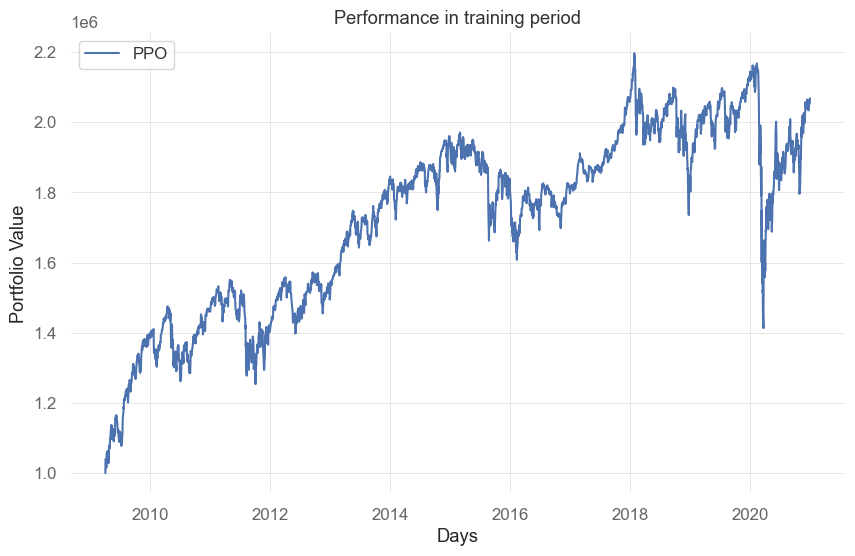

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(A2C_results["date"], A2C_results["training"], label="A2C")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

In [ ]:
UBAH_results = {
    "train": {},
    "2021": {},
    "2022": {},
    "2023": {},
}

PORTFOLIO_SIZE = len(DOW_30_TICKER)



# This is the CRP strategy NOT Buy and hold 
# train period
terminated = False
environment.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment.step(action)
UBAH_results["train"]["value"] = environment._terminal_asset_memory["final"]
UBAH_results["train"]["date"] = environment._terminal_date_memory

# 2021
terminated = False
environment_2021.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2021.step(action)
UBAH_results["2021"]["value"] = environment_2021._terminal_asset_memory["final"]
UBAH_results["2021"]["date"] = environment_2021._terminal_date_memory

# 2022
terminated = False
environment_2022.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2022.step(action)
UBAH_results["2022"]["value"] = environment_2022._terminal_asset_memory["final"]
UBAH_results["2022"]["date"] = environment_2022._terminal_date_memory

# # 2023
# terminated = False
# environment_2023.reset()
# while not terminated:
#     action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
#     _, _, terminated, _ = environment_2023.step(action)
# UBAH_results["2023"]["value"] = environment_2023._terminal_asset_memory["final"]
# UBAH_results["2023"]["date"] = environment_2023._terminal_date_memory

Initial portfolio value:1000000
Final portfolio value: 7940024.5
Final accumulative portfolio value: 7.9400245
Maximum DrawDown: -0.3311966144276043
Sharpe ratio: 1.1059670207527874
Total commission cost: 87049.04863685812
Initial portfolio value:1000000
Final portfolio value: 1213572.25
Final accumulative portfolio value: 1.21357225
Maximum DrawDown: -0.066131415363884
Sharpe ratio: 1.6869003252389
Total commission cost: 2419.68145453115
Initial portfolio value:1000000
Final portfolio value: 921181.3125
Final accumulative portfolio value: 0.9211813125
Maximum DrawDown: -0.21710117621358893
Sharpe ratio: -0.31400174168601175
Total commission cost: 2328.9109759511193


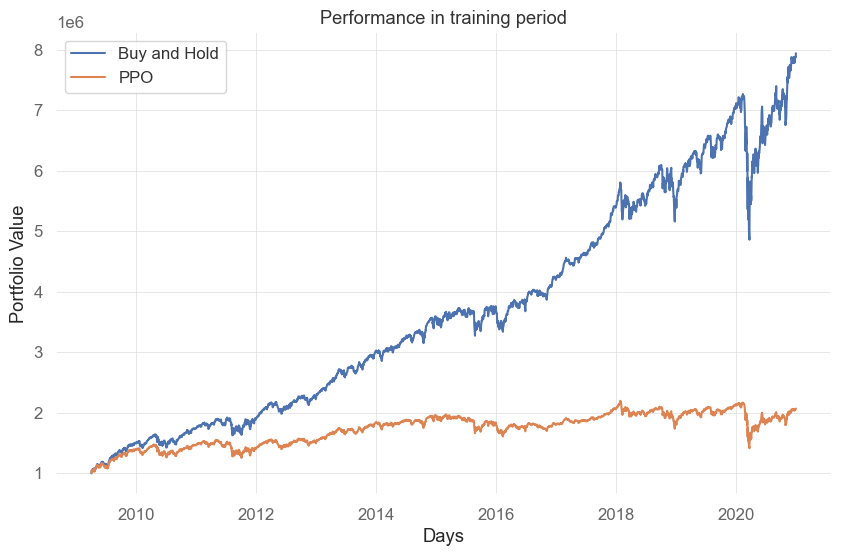

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["date"], UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(A2C_results["date"], A2C_results["training"], label="A2C")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

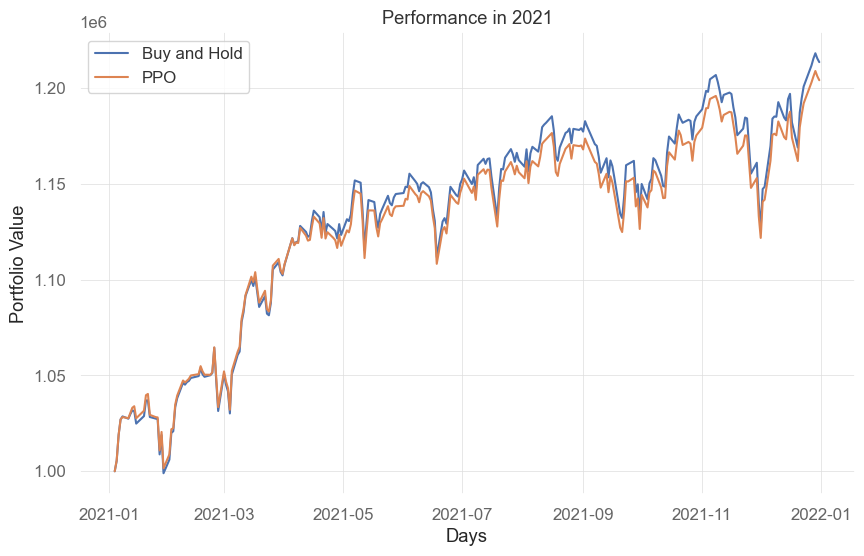

In [ ]:
plt.plot(UBAH_results["2021"]["date"], UBAH_results["2021"]["value"], label="Buy and Hold")
plt.plot(A2C_results["2021"]["date"], A2C_results["2021"]["value"], label="A2C")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2021")
plt.legend()

plt.show()

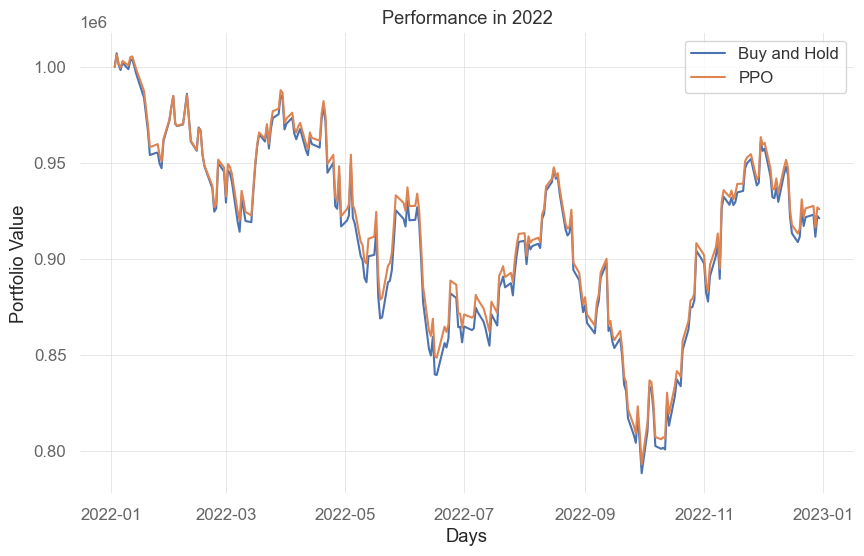

In [ ]:
plt.plot(UBAH_results["2022"]["date"], UBAH_results["2022"]["value"], label="Buy and Hold")
plt.plot(A2C_results["2022"]["date"], A2C_results["2022"]["value"], label="A2C")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2022")
plt.legend()

plt.show()

In [ ]:
# plt.plot(UBAH_results["2023"]["date"], UBAH_results["2023"]["value"], label="Buy and Hold")
# plt.plot(A2C_results["2023"]["date"], A2C_results["2023"]["value"], label="A2C")

# plt.xlabel("Days")
# plt.ylabel("Portfolio Value")
# plt.title("Performance in 2023")
# plt.legend()

# plt.show()